# Deep Convolutional GANs (DCGANs) by `Mr. Harshit Dawar!`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf

## Loading the dataset & Visualizing it!

In [97]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [98]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

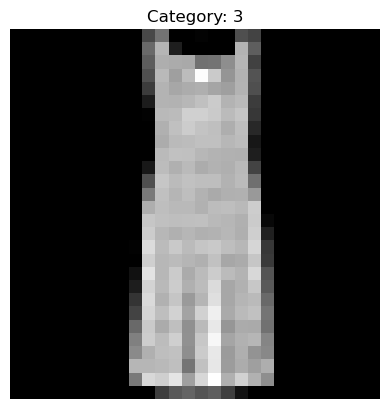

In [99]:
random_image = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_image], cmap = "gray")
plt.title("Category: " + str(y_train[random_image]))
plt.axis("off")
plt.show()

In [100]:
# Generating the 3rd Dimenstion for the image as per the requirement of the task
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [101]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
# X_train = tf.convert_to_tensor(X_train, dtype = tf.int64)
# X_test = tf.convert_to_tensor(X_test, dtype = tf.int64)

In [102]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [103]:
# Normalizing the images between -1 to 1
X_train = (X_train - 127.5) / 127.5

In [104]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [105]:
batch_size = 64
total_images = X_train.shape[0]
total_number_of_batches = total_images / batch_size

In [106]:
total_number_of_batches

937.5

In [107]:
X_train[0].dtype

dtype('float32')

In [108]:
# Changing the type of X_train from numpy array to tensorflow batchdataset
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(total_images).batch(batch_size)

In [109]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Creating the Generator for the GANs

In [114]:
def generator_builder():
    model = tf.keras.Sequential()
    
    # For the Random Noise/Image of a vector shape of 100 
    model.add(ly.Dense(units = 7 * 7 * 512, use_bias = False, input_shape = (100, )))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # To Reshape the above flattened vector
    model.add(ly.Reshape((7, 7, 512)))
    
    # Conv2DTranspose Block 1 for generating a bigger image : Image size is 7x7x256
    model.add(ly.Conv2DTranspose(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 2 for generating a bigger image : Image size is 14x14x128
    model.add(ly.Conv2DTranspose(filters = 128, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 3 for generating a bigger image : Image size is 28x28x1
    model.add(ly.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = True, activation = "tanh"))
    
    model.summary()
    return model

In [116]:
# Defining a generator
generator = generator_builder()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25088)             2508800   
                                                                 
 batch_normalization_6 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 25088)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 256)        1179648   
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 256)       

In [119]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_3_input')>

In [120]:
random_noise = tf.random.normal([1, 100])

In [121]:
random_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.07399955,  0.4418197 , -0.42029044,  0.3528369 , -1.5195401 ,
         0.5627583 ,  1.5703695 , -0.27022937, -0.75913537,  0.9561205 ,
         0.76884   , -0.9379511 ,  0.2987878 , -1.2310134 , -0.41081038,
         1.952765  , -0.29831263,  0.18207571,  0.19739448,  0.51675117,
         0.2914938 , -0.9856544 , -0.6427645 ,  0.775242  ,  0.41495836,
         1.0179718 , -1.3159829 ,  0.6281537 , -0.90272576,  0.11016165,
         0.13467327,  0.90947497,  0.18068807,  1.3037506 , -1.19341   ,
        -1.1975288 ,  0.6937465 , -1.0313374 ,  0.09066112,  1.3569673 ,
         0.5120963 , -1.4577396 , -2.010946  ,  0.55753684, -0.5484317 ,
         0.61109865,  0.09882175, -0.6403067 , -0.03540858,  0.88208383,
         0.57447827, -1.4577205 , -1.7406185 ,  0.4336721 , -1.2524939 ,
         1.7157068 , -1.2084976 ,  1.0526701 , -0.3296681 , -1.6240891 ,
        -1.2011055 , -1.5513663 , -0.23325479,  0.1128914 , -2.0134032 ,
 

In [132]:
random_image_generated_from_generator = generator(random_noise, training = False)

In [133]:
random_image_generated_from_generator.shape

TensorShape([1, 28, 28, 1])

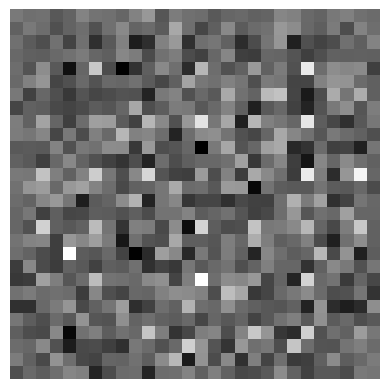

In [134]:
plt.imshow(random_image_generated_from_generator[0], cmap = "gray")
plt.axis("off")
plt.show()